# Elo Rating and Robustness Check

Paper: "The Making of Modern NCAA Football Head Coaches"
<br> Authors: Oyvind Aas, Tuan M. Nguyen & Patrick Legros

File Objective: Create Elo rating system and robustness check modifications

Note: 
1. Full schedule from 1930 to 2016.
2. Exclude games with high school teams and junior varsity teams.
3. Exclude missing date games

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss
import math
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from decimal import Decimal, localcontext

### 1. Count the number of games each team plays

In [2]:
game_count=pd.read_csv("game_count.csv")
game_count['count'] = game_count.groupby('team')['team'].transform('count')
game_count.to_csv("game_count_value.csv", index=None)

### 2. Use excel to match count to schedule


### 3. Import schedule with count values


In [3]:
sc = pd.read_csv("python_elo.csv")

#Drop games with teams play less than 30 games (about 3 seasons)
sc30=sc[(sc['win_game_count']>30) & (sc['lose_game_count']>30)]
sc30.to_csv("schedule_30.csv", index=None)



#set up initial Elo for teams
team_ids = set(sc30.win_code).union(set(sc30.lose_code))

### 4. Run Calibration

Model specifications:
1. Benchmark model 1: win-loss + home_advantage + margin + scale 400 --> min quad_loss 1954
2. Benchmark model 2: win-loss + home_advantage + margin + scale 400 --> min log_loss 1954


3. Model 2.1: win-loss + home_advantage + margin + scale 400 --> min quad_loss all games
4. Model 2.2: win-loss + home_advantage + margin + scale 400 --> min log_loss all games


5. Model 3.1: win-loss + scale 400 --> min quad_loss 1954
6. Model 3.2: win-loss + scale 400 --> min log_loss 1954


7. Model 4.1: win-loss + home_advantage + margin + scale 200 --> min quad_loss 1954
8. Model 4.2: win-loss + home_advantage + margin + scale 200 --> min log_loss 1954


9. Model 5.1: win-loss + home_advantage + margin + scale 600 --> min quad_loss 1954
10. Model 5.2: win-loss + home_advantage + margin + scale 600 --> min log_loss 1954

#### 4.1 Benchmark Models (bm) & Model 2

In [4]:
#import new schedule
sc_bm=pd.read_csv("schedule_30.csv")

#create margin column
sc_bm['margin'] = sc_bm['win_point'] - sc_bm['lose_point']



In [5]:
#Elo prediction
def elo_pred(elo1, elo2):
    return(1. / (10. ** (-(elo1 - elo2) / 400.) + 1.))
    
#Update new Elo with result
def elo_update(w_elo, l_elo, margin):
    elo_diff = w_elo - l_elo
    pred = elo_pred(w_elo, l_elo)
    pd = abs(margin)
    mult = math.log(max(pd, 1) + 1.0)* (2.2 / (1.0 if score == 0.5 else ((elo_diff if score == 1.0 else -elo_diff) * 0.001 + 2.2))) 
    update = K * (bowl**0)* mult * (score - pred)
    return(pred, update)



In [6]:
#Run loop for K and HOME_ADVANTAGE
loss_function_bm = []

for K in range(10,70,5):
    for HOME_ADVANTAGE in range(40,150,10):
        
        elo_dict = dict(zip(list(team_ids), [1500] * len(team_ids)))

        #Run loops
        preds = []
        w_elo = []
        l_elo = []

        # Loop over all rows of the games dataframe
        for row in sc_bm.itertuples():

            # Get key data from current row
            w = row.win_code
            l = row.lose_code
            margin = row.margin
            wloc = row.wloc
            score=row.score
            bowl=row.bowl
                   

            # Does either team get a home-court advantage?
            w_ad, l_ad, = 0., 0.
            if wloc == "H":
                w_ad += HOME_ADVANTAGE
            elif wloc == "A":
                l_ad += HOME_ADVANTAGE

            # Get elo updates as a result of the game
            pred, update = elo_update(elo_dict[w]+w_ad, elo_dict[l]+l_ad, margin)

            # Save prediction and new Elos for each round
            preds.append(pred)
            w_elo.append(elo_dict[w])
            l_elo.append(elo_dict[l])

            elo_dict[w] += update
            elo_dict[l] -= update

        #Create new elo columns
        sc_bm['w_elo'] = w_elo
        sc_bm['l_elo'] = l_elo
        sc_bm['preds'] = preds
        sc_bm['quadratic_loss']=(sc_bm['preds']-sc_bm['score'])**2
        sc_bm_1954 = sc_bm.loc[sc_bm['season']>=1954]
                       
        quad_loss_bm_1954=np.mean(sc_bm_1954.quadratic_loss)
        log_loss_bm_1954=np.mean(-np.log(sc_bm_1954.preds))
            
        quad_loss_bm=np.mean(sc_bm.quadratic_loss)
        log_loss_bm=np.mean(-np.log(sc_bm.preds))
            
        loss_function_bm.append([K, HOME_ADVANTAGE, quad_loss_bm,
                                  log_loss_bm, quad_loss_bm_1954, log_loss_bm_1954])

In [7]:
#Store loss functions    
df_bm=pd.DataFrame(loss_function_bm)
df_bm.columns = ['K','HOME_ADVANTAGE', 'quad_loss_bm', 'log_loss_bm',
             'quad_loss_bm_1954', 'log_loss_bm_1954']

In [8]:
#Find optimal values quad_loss
print(df_bm[df_bm.quad_loss_bm == df_bm.quad_loss_bm.min()]) 
#Find optimal values log_loss
print(df_bm[df_bm.log_loss_bm == df_bm.log_loss_bm.min()]) 

#Find optimal values quad_loss
print(df_bm[df_bm.quad_loss_bm_1954 == df_bm.quad_loss_bm_1954.min()]) 
#Find optimal values log_loss
print(df_bm[df_bm.log_loss_bm_1954 == df_bm.log_loss_bm_1954.min()]) 

     K  HOME_ADVANTAGE  quad_loss_bm  log_loss_bm  quad_loss_bm_1954  \
73  40             110      0.171461      0.53264           0.173091   

    log_loss_bm_1954  
73          0.531617  
     K  HOME_ADVANTAGE  quad_loss_bm  log_loss_bm  quad_loss_bm_1954  \
61  35             100      0.171492     0.531243           0.172952   

    log_loss_bm_1954  
61          0.529499  
     K  HOME_ADVANTAGE  quad_loss_bm  log_loss_bm  quad_loss_bm_1954  \
61  35             100      0.171492     0.531243           0.172952   

    log_loss_bm_1954  
61          0.529499  
     K  HOME_ADVANTAGE  quad_loss_bm  log_loss_bm  quad_loss_bm_1954  \
49  30              90      0.172012      0.53147           0.173284   

    log_loss_bm_1954  
49          0.528988  


Text(33.0, 0.5, '$k_{0}$')

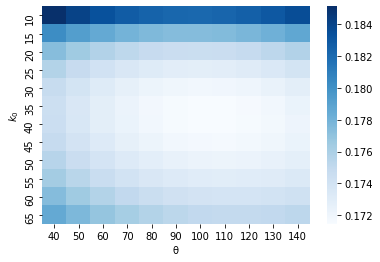

In [9]:
quad_map_bm=df_bm.pivot("K","HOME_ADVANTAGE", "quad_loss_bm")
sns.heatmap(quad_map_bm, cmap="Blues")
plt.xlabel('\u03B8')
plt.ylabel('$k_{0}$')


Text(33.0, 0.5, '$k_{0}$')

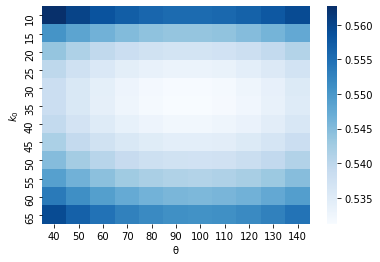

In [10]:
log_map_bm=df_bm.pivot("K","HOME_ADVANTAGE", "log_loss_bm")
sns.heatmap(log_map_bm, cmap="Blues")
plt.xlabel('\u03B8')
plt.ylabel('$k_{0}$')

Results:

1. Benchmark model 1: 
    K = 35; Home_Ad = 100
    
    
2. Benchmark model 2: 
   K = 30; Home_Ad = 90 

3. Model 2.1: 
    K = 40; Home_Ad = 110
    
    
4. Model 2.2: 
    K = 35; Home_Ad = 100
    
 

#### 4.2 Model 3: win-loss + scale 400 


In [11]:
#import new schedule
sc_3=pd.read_csv("schedule_30.csv")

#create margin column
sc_3['margin'] = sc_3['win_point'] - sc_3['lose_point']

#Elo prediction
def elo_pred(elo1, elo2):
    return(1. / (10. ** (-(elo1 - elo2) / 400.) + 1.))
    
#Update new Elo with result
def elo_update(w_elo, l_elo, margin):
    elo_diff = w_elo - l_elo
    pred = elo_pred(w_elo, l_elo)
    pd = abs(margin)
    update = K *  (score - pred)
    return(pred, update)

#Run loop for K and HOME_ADVANTAGE
loss_function_3 = []

HOME_ADVANTAGE = 0 
for K in range(10,120,5): 
        elo_dict = dict(zip(list(team_ids), [1500] * len(team_ids)))

        #Run loops
        preds = []
        w_elo = []
        l_elo = []

        # Loop over all rows of the games dataframe
        for row in sc_3.itertuples():

            # Get key data from current row
            w = row.win_code
            l = row.lose_code
            margin = row.margin
            wloc = row.wloc
            score=row.score
            bowl=row.bowl
                   

            # Does either team get a home-court advantage?
            w_ad, l_ad, = 0., 0.
            if wloc == "H":
                w_ad += HOME_ADVANTAGE
            elif wloc == "A":
                l_ad += HOME_ADVANTAGE

            # Get elo updates as a result of the game
            pred, update = elo_update(elo_dict[w]+w_ad, elo_dict[l]+l_ad, margin)

            # Save prediction and new Elos for each round
            preds.append(pred)
            w_elo.append(elo_dict[w])
            l_elo.append(elo_dict[l])

            elo_dict[w] += update
            elo_dict[l] -= update

        #Create new elo columns
        sc_3['w_elo'] = w_elo
        sc_3['l_elo'] = l_elo
        sc_3['preds'] = preds
        sc_3['quadratic_loss']=(sc_3['preds']-sc_3['score'])**2
        sc_3_1954 = sc_3.loc[sc_3['season']>=1954]
                       
        quad_loss_3_1954=np.mean(sc_3_1954.quadratic_loss)
        log_loss_3_1954=np.mean(-np.log(sc_3_1954.preds))
            
        quad_loss_3=np.mean(sc_3.quadratic_loss)
        log_loss_3=np.mean(-np.log(sc_3.preds))
            
        loss_function_3.append([K,  quad_loss_3,
                                  log_loss_3, quad_loss_3_1954, log_loss_3_1954])

#Store loss functions    
df_3=pd.DataFrame(loss_function_3)
df_3.columns = ['K', 'quad_loss_3', 'log_loss_3',
             'quad_loss_3_1954', 'log_loss_3_1954']

#Find optimal values quad_loss
print(df_3[df_3.quad_loss_3 == df_3.quad_loss_3.min()]) 
#Find optimal values log_loss
print(df_3[df_3.log_loss_3 == df_3.log_loss_3.min()]) 

#Find optimal values quad_loss
print(df_3[df_3.quad_loss_3_1954 == df_3.quad_loss_3_1954.min()]) 
#Find optimal values log_loss
print(df_3[df_3.log_loss_3_1954 == df_3.log_loss_3_1954.min()]) 

     K  quad_loss_3  log_loss_3  quad_loss_3_1954  log_loss_3_1954
16  90     0.183583    0.562021           0.18442         0.558625
     K  quad_loss_3  log_loss_3  quad_loss_3_1954  log_loss_3_1954
14  80     0.183733    0.561415          0.184428         0.557506
     K  quad_loss_3  log_loss_3  quad_loss_3_1954  log_loss_3_1954
15  85     0.183623    0.561612          0.184391         0.557963
     K  quad_loss_3  log_loss_3  quad_loss_3_1954  log_loss_3_1954
13  75     0.183919    0.561449          0.184539         0.557277


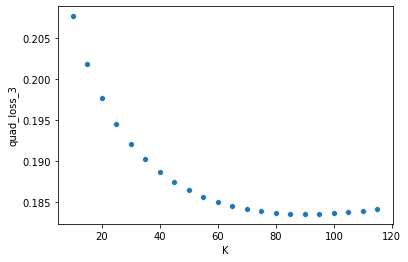

In [12]:
ax_3_quad = sns.scatterplot(x="K", y="quad_loss_3",
                     data=df_3)

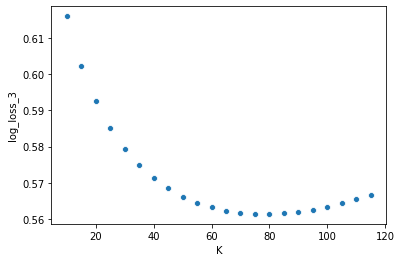

In [13]:
ax_3_log = sns.scatterplot(x="K", y="log_loss_3",
                     data=df_3)

Results

#### 4.3 Model 4

In [14]:
#import new schedule
sc_4=pd.read_csv("schedule_30.csv")

#create margin column
sc_4['margin'] = sc_4['win_point'] - sc_4['lose_point']

#Elo prediction
def elo_pred(elo1, elo2):
    return(1. / (10. ** (-(elo1 - elo2) / 200.) + 1.))
    
#Update new Elo with result
def elo_update(w_elo, l_elo, margin):
    elo_diff = w_elo - l_elo
    pred = elo_pred(w_elo, l_elo)
    pd = abs(margin)
    mult = math.log(max(pd, 1) + 1.0)* (2.2 / (1.0 if score == 0.5 else ((elo_diff if score == 1.0 else -elo_diff) * 0.001 + 2.2))) 
    update = K *  mult * (score - pred)
    return(pred, update)


#Run loop for K and HOME_ADVANTAGE
loss_function_4 = []

for K in range(10,70,5):
    for HOME_ADVANTAGE in range(30,150,10):
        
        elo_dict = dict(zip(list(team_ids), [1500] * len(team_ids)))

        #Run loops
        preds = []
        w_elo = []
        l_elo = []

        # Loop over all rows of the games dataframe
        for row in sc_4.itertuples():

            # Get key data from current row
            w = row.win_code
            l = row.lose_code
            margin = row.margin
            wloc = row.wloc
            score=row.score
            bowl=row.bowl
                   

            # Does either team get a home-court advantage?
            w_ad, l_ad, = 0., 0.
            if wloc == "H":
                w_ad += HOME_ADVANTAGE
            elif wloc == "A":
                l_ad += HOME_ADVANTAGE

            # Get elo updates as a result of the game
            pred, update = elo_update(elo_dict[w]+w_ad, elo_dict[l]+l_ad, margin)

            # Save prediction and new Elos for each round
            preds.append(pred)
            w_elo.append(elo_dict[w])
            l_elo.append(elo_dict[l])

            elo_dict[w] += update
            elo_dict[l] -= update

        #Create new elo columns
        sc_4['w_elo'] = w_elo
        sc_4['l_elo'] = l_elo
        sc_4['preds'] = preds
        sc_4['quadratic_loss']=(sc_4['preds']-sc_4['score'])**2
        sc_4_1954 = sc_4.loc[sc_4['season']>=1954]
                       
        quad_loss_4_1954=np.mean(sc_4_1954.quadratic_loss)
        log_loss_4_1954=np.mean(-np.log(sc_4_1954.preds))
            
        quad_loss_4=np.mean(sc_4.quadratic_loss)
        log_loss_4=np.mean(-np.log(sc_4.preds))
            
        loss_function_4.append([K, HOME_ADVANTAGE, quad_loss_4,
                                  log_loss_4, quad_loss_4_1954, log_loss_4_1954])
        
#Store loss functions    
df_4=pd.DataFrame(loss_function_4)
df_4.columns = ['K','HOME_ADVANTAGE', 'quad_loss_4', 'log_loss_4',
             'quad_loss_4_1954', 'log_loss_4_1954']

#Find optimal values quad_loss
print(df_4[df_4.quad_loss_4 == df_4.quad_loss_4.min()]) 
#Find optimal values log_loss
print(df_4[df_4.log_loss_4 == df_4.log_loss_4.min()]) 

#Find optimal values quad_loss
print(df_4[df_4.quad_loss_4_1954 == df_4.quad_loss_4_1954.min()]) 
#Find optimal values log_loss
print(df_4[df_4.log_loss_4_1954 == df_4.log_loss_4_1954.min()]) 

     K  HOME_ADVANTAGE  quad_loss_4  log_loss_4  quad_loss_4_1954  \
26  20              50     0.172743     0.53691          0.174414   

    log_loss_4_1954  
26         0.536185  
     K  HOME_ADVANTAGE  quad_loss_4  log_loss_4  quad_loss_4_1954  \
14  15              50     0.173256    0.535731          0.174665   

    log_loss_4_1954  
14         0.533899  
     K  HOME_ADVANTAGE  quad_loss_4  log_loss_4  quad_loss_4_1954  \
26  20              50     0.172743     0.53691          0.174414   

    log_loss_4_1954  
26         0.536185  
     K  HOME_ADVANTAGE  quad_loss_4  log_loss_4  quad_loss_4_1954  \
14  15              50     0.173256    0.535731          0.174665   

    log_loss_4_1954  
14         0.533899  


Text(33.0, 0.5, '$k_{0}$')

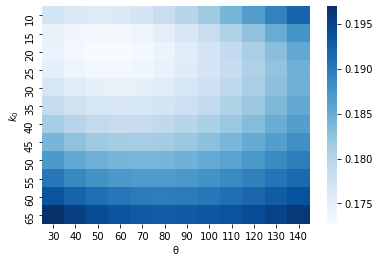

In [15]:
quad_map_4=df_4.pivot("K","HOME_ADVANTAGE", "quad_loss_4")
sns.heatmap(quad_map_4, cmap="Blues")
plt.xlabel('\u03B8')
plt.ylabel('$k_{0}$')

Text(33.0, 0.5, '$k_{0}$')

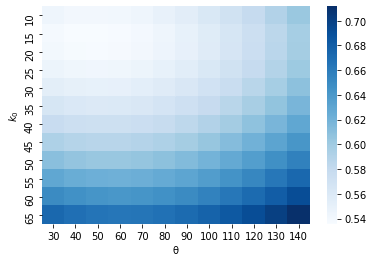

In [16]:
log_map_4=df_4.pivot("K","HOME_ADVANTAGE", "log_loss_4")
sns.heatmap(log_map_4, cmap="Blues")
plt.xlabel('\u03B8')
plt.ylabel('$k_{0}$')

#### 4.4 Model 5

In [17]:
#import new schedule
sc_5=pd.read_csv("schedule_30.csv")

#create margin column
sc_5['margin'] = sc_5['win_point'] - sc_5['lose_point']

#Elo prediction
def elo_pred(elo1, elo2):
    elo_diff = elo1 - elo2
    if elo_diff >= 3000:
        Y = 0.99999
    elif elo_diff <=-3000:
        Y = 0.00001
    else:
        Y = 1.0 / (10.0 ** (-(elo_diff) / 600.0) + 1.0)
    return(Y)

#Update new Elo with result
def elo_update(w_elo, l_elo, margin):
    elo_diff = w_elo - l_elo
    pred = elo_pred(w_elo, l_elo)
    pd = abs(margin)
    mult = math.log(max(pd, 1) + 1)* (2.2 / (1.0 if score == 0.5 else ((elo_diff if score == 1 else -elo_diff) * 0.001 + 2.2))) 
    update = K *  mult * (score - pred)
    return(pred, update)


#Run loop for K and HOME_ADVANTAGE
loss_function_5 = []

for K in range(10,80,5):
    for HOME_ADVANTAGE in range(30,150,10):
        
        elo_dict = dict(zip(list(team_ids), [1500] * len(team_ids)))

        #Run loops
        preds = []
        w_elo = []
        l_elo = []

        # Loop over all rows of the games dataframe
        for row in sc_5.itertuples():

            # Get key data from current row
            w = row.win_code
            l = row.lose_code
            margin = row.margin
            wloc = row.wloc
            score=row.score
            bowl=row.bowl
                   

            # Does either team get a home-court advantage?
            w_ad, l_ad, = 0, 0
            if wloc == "H":
                w_ad += HOME_ADVANTAGE
            elif wloc == "A":
                l_ad += HOME_ADVANTAGE

            # Get elo updates as a result of the game
            pred, update = elo_update(elo_dict[w]+w_ad, elo_dict[l]+l_ad, margin)

            # Save prediction and new Elos for each round
            preds.append(pred)
            w_elo.append(elo_dict[w])
            l_elo.append(elo_dict[l])

            elo_dict[w] += update
            elo_dict[l] -= update

        #Create new elo columns
        sc_5['w_elo'] = w_elo
        sc_5['l_elo'] = l_elo
        sc_5['preds'] = preds
        sc_5['quadratic_loss']=(sc_5['preds']-sc_5['score'])**2
        sc_5_1954 = sc_5.loc[sc_5['season']>=1954]
                       
        quad_loss_5_1954=np.mean(sc_5_1954.quadratic_loss)
        log_loss_5_1954=np.mean(-np.log(sc_5_1954.preds))
            
        quad_loss_5=np.mean(sc_5.quadratic_loss)
        log_loss_5=np.mean(-np.log(sc_5.preds))
            
        loss_function_5.append([K, HOME_ADVANTAGE, quad_loss_5,
                                  log_loss_5, quad_loss_5_1954, log_loss_5_1954])
        
#Store loss functions    
df_5=pd.DataFrame(loss_function_5)
df_5.columns = ['K','HOME_ADVANTAGE', 'quad_loss_5', 'log_loss_5',
             'quad_loss_5_1954', 'log_loss_5_1954']

#Find optimal values quad_loss
print(df_5[df_5.quad_loss_5 == df_5.quad_loss_5.min()]) 
#Find optimal values log_loss
print(df_5[df_5.log_loss_5 == df_5.log_loss_5.min()]) 

#Find optimal values quad_loss
print(df_5[df_5.quad_loss_5_1954 == df_5.quad_loss_5_1954.min()]) 
#Find optimal values log_loss
print(df_5[df_5.log_loss_5_1954 == df_5.log_loss_5_1954.min()]) 

      K  HOME_ADVANTAGE  quad_loss_5  log_loss_5  quad_loss_5_1954  \
107  50             140     0.170612    0.527787          0.171948   

     log_loss_5_1954  
107         0.525419  
      K  HOME_ADVANTAGE  quad_loss_5  log_loss_5  quad_loss_5_1954  \
107  50             140     0.170612    0.527787          0.171948   

     log_loss_5_1954  
107         0.525419  
      K  HOME_ADVANTAGE  quad_loss_5  log_loss_5  quad_loss_5_1954  \
107  50             140     0.170612    0.527787          0.171948   

     log_loss_5_1954  
107         0.525419  
     K  HOME_ADVANTAGE  quad_loss_5  log_loss_5  quad_loss_5_1954  \
95  45             140     0.170881    0.528051          0.172098   

    log_loss_5_1954  
95         0.525275  


Text(33.0, 0.5, '$k_{0}$')

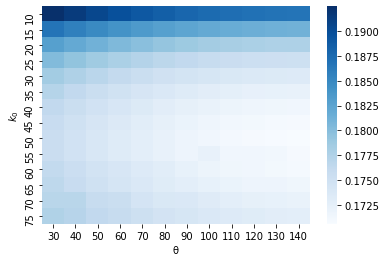

In [18]:
quad_map_5=df_5.pivot("K","HOME_ADVANTAGE", "quad_loss_5")
sns.heatmap(quad_map_5, cmap="Blues")
plt.xlabel('\u03B8')
plt.ylabel('$k_{0}$')

Text(33.0, 0.5, '$k_{0}$')

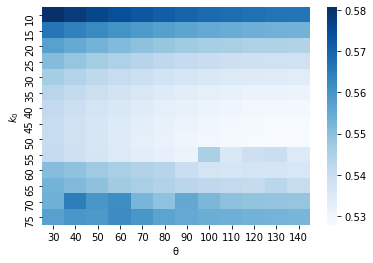

In [19]:
log_map_5=df_5.pivot("K","HOME_ADVANTAGE", "log_loss_5")
sns.heatmap(log_map_5, cmap="Blues")
plt.xlabel('\u03B8')
plt.ylabel('$k_{0}$')

In [20]:
sc_5.tail()

,sort_id,index,duplicate,url,win_team,win_code,win_point,lose_point,winloss,score,...,note,bowl,wloc,win_game_count,lose_game_count,margin,w_elo,l_elo,preds,quadratic_loss
213731,219148,221602,0,https://www.cfbdatawarehouse.com/data/active/k...,Fort Hays St. (KS),1237,26,0,W,1.0,...,NaN,1,A,850,853,26,2037.941845,826.173617,0.983906,2.590277e-04
213732,219149,225963,0,https://www.cfbdatawarehouse.com/data/active/s...,Southwestern (KS),1356,27,7,W,1.0,...,NaN,1,N,893,214,20,-6827.100152,1315.810981,0.000010,9.999800e-01
213733,219150,212694,0,https://www.cfbdatawarehouse.com/data/active/j...,Maryland,1110,14,0,W,1.0,...,NaN,1,A,970,893,14,13426.600644,1388.248314,0.999990,1.000000e-10
213734,219151,223547,0,https://www.cfbdatawarehouse.com/data/active/m...,Notre Dame (IN),1270,14,6,W,1.0,...,NaN,1,A,955,899,8,2792.570231,-19143.420975,0.999990,1.000000e-10
213735,219152,225964,0,https://www.cfbdatawarehouse.com/data/active/s...,Pittsburg St. (KS),1186,13,10,W,1.0,...,NaN,1,H,921,893,3,9104.379033,-6911.627948,0.999990,1.000000e-10


## 5. Export models to files

In [21]:
print("Benchmark")
#Find optimal values quad_loss
print(df_bm[df_bm.quad_loss_bm_1954 == df_bm.quad_loss_bm_1954.min()]) 
#Find optimal values log_loss
print(df_bm[df_bm.log_loss_bm_1954 == df_bm.log_loss_bm_1954.min()]) 

print("\n")
print("Model 2")
#Find optimal values quad_loss
print(df_bm[df_bm.quad_loss_bm == df_bm.quad_loss_bm.min()]) 
#Find optimal values log_loss
print(df_bm[df_bm.log_loss_bm == df_bm.log_loss_bm.min()]) 
print("\n")
print("\n")

print("Model 3")
#Find optimal values quad_loss
print(df_3[df_3.quad_loss_3_1954 == df_3.quad_loss_3_1954.min()]) 
#Find optimal values log_loss
print(df_3[df_3.log_loss_3_1954 == df_3.log_loss_3_1954.min()]) 
print("\n")

print("Model 4")
#Find optimal values quad_loss
print(df_4[df_4.quad_loss_4_1954 == df_4.quad_loss_4_1954.min()]) 
#Find optimal values log_loss
print(df_4[df_4.log_loss_4_1954 == df_4.log_loss_4_1954.min()]) 
print("\n")

print("Model 5")
#Find optimal values quad_loss
print(df_5[df_5.quad_loss_5_1954 == df_5.quad_loss_5_1954.min()]) 
#Find optimal values log_loss
print(df_5[df_5.log_loss_5_1954 == df_5.log_loss_5_1954.min()]) 

Benchmark
     K  HOME_ADVANTAGE  quad_loss_bm  log_loss_bm  quad_loss_bm_1954  \
61  35             100      0.171492     0.531243           0.172952   

    log_loss_bm_1954  
61          0.529499  
     K  HOME_ADVANTAGE  quad_loss_bm  log_loss_bm  quad_loss_bm_1954  \
49  30              90      0.172012      0.53147           0.173284   

    log_loss_bm_1954  
49          0.528988  


Model 2
     K  HOME_ADVANTAGE  quad_loss_bm  log_loss_bm  quad_loss_bm_1954  \
73  40             110      0.171461      0.53264           0.173091   

    log_loss_bm_1954  
73          0.531617  
     K  HOME_ADVANTAGE  quad_loss_bm  log_loss_bm  quad_loss_bm_1954  \
61  35             100      0.171492     0.531243           0.172952   

    log_loss_bm_1954  
61          0.529499  




Model 3
     K  quad_loss_3  log_loss_3  quad_loss_3_1954  log_loss_3_1954
15  85     0.183623    0.561612          0.184391         0.557963
     K  quad_loss_3  log_loss_3  quad_loss_3_1954  log_loss_3_1954
13 

Results:

1. Benchmark model 1: 
    K = 35; Home_Ad = 100: quad_loss_1954 = 0.172952
   
2. Benchmark model 2: 
   K = 30; Home_Ad = 90: log_loss_1954 = 0.528988
   
   
3. Model 2.1: 
   K = 40; Home_Ad = 110: quad_loss = 0.171461
    
4. Model 2.2: 
   K = 35; Home_Ad = 100: log_loss = 0.531243
    
    
5. Model 3.1
   K = 85: quad_loss_1954 = 0.184391

6. Model 3.2
   K = 75: log_loss_1954 = 0.557277
   

7. Model 4.1
   K = 20; Home_Ad = 50: quad_loss_1954 = 0.174414

8. Model 4.2
   K = 15; Home_Ad = 50: log_loss_1954 = 0.533899
   

9. Model 5.1
   K = 50; Home_Ad = 140: quad_loss_1954 = 0.171948

10. Model 5.2
   K = 45; Home_Ad = 140: log_loss_1954 = 0.525275  

## 5.1 Benchmark Models

In [22]:
#import new schedule
model_bm1=pd.read_csv("schedule_30.csv")

#create margin column
model_bm1['margin'] = model_bm1['win_point'] - model_bm1['lose_point']

#Elo prediction
def elo_pred(elo1, elo2):
    return(1.0 / (10.0 ** (-(elo1 - elo2) / 400) + 1.0))
    
#Update new Elo with result
def elo_update(w_elo, l_elo, margin):
    elo_diff = w_elo - l_elo
    pred = elo_pred(w_elo, l_elo)
    pd = abs(margin)
    mult = math.log(max(pd, 1) + 1)* (2.2 / (1.0 if score == 0.5 else ((elo_diff if score == 1 else -elo_diff) * 0.001 + 2.2))) 
    update = K *  mult * (score - pred)
    return(pred, update)


#Run loop for K and HOME_ADVANTAGE
K = 35
HOME_ADVANTAGE = 100
     
elo_dict = dict(zip(list(team_ids), [1500] * len(team_ids)))

#Run loops
preds = []
w_elo = []
l_elo = []

# Loop over all rows of the games dataframe
for row in model_bm1.itertuples():

    # Get key data from current row
    w = row.win_code
    l = row.lose_code
    margin = row.margin
    wloc = row.wloc
    score=row.score
    bowl=row.bowl


    # Does either team get a home-court advantage?
    w_ad, l_ad, = 0, 0
    if wloc == "H":
        w_ad += HOME_ADVANTAGE
    elif wloc == "A":
        l_ad += HOME_ADVANTAGE

    # Get elo updates as a result of the game
    pred, update = elo_update(elo_dict[w]+w_ad, elo_dict[l]+l_ad, margin)

    # Save prediction and new Elos for each round
    preds.append(pred)
    w_elo.append(elo_dict[w])
    l_elo.append(elo_dict[l])

    elo_dict[w] += update
    elo_dict[l] -= update

#Create new elo columns
model_bm1['w_elo'] = w_elo
model_bm1['l_elo'] = l_elo
model_bm1['preds'] = preds


#Export to file
def final_elo_per_season(df, team_id):
    d = df.copy()
    d = d.loc[(d.win_code == team_id) | (d.lose_code == team_id), :]
    d.sort_values(['season', 'sort_id'], inplace=True)
    d.drop_duplicates(['season'], keep='last', inplace=True)
    w_mask = d.win_code == team_id
    l_mask = d.lose_code == team_id
    d['season_elo_bm1'] = None
    d.loc[w_mask, 'season_elo_bm1'] = d.loc[w_mask, 'w_elo']
    d.loc[l_mask, 'season_elo_bm1'] = d.loc[l_mask, 'l_elo']
    out = pd.DataFrame({
        'team_id': team_id,
        'season': d.season,
        'season_elo_bm1': d.season_elo_bm1
    })
    return(out)

df_list_bm1 = [final_elo_per_season(model_bm1, id) for id in team_ids]
season_elos_bm1 = pd.concat(df_list_bm1)
team_code_bm1=pd.read_csv('team_code.csv')
season_elos_name_bm1=season_elos_bm1.join(team_code_bm1.set_index('team_id'), on='team_id')



In [23]:
#import new schedule
model_bm2=pd.read_csv("schedule_30.csv")

#create margin column
model_bm2['margin'] = model_bm2['win_point'] - model_bm2['lose_point']

#Elo prediction
def elo_pred(elo1, elo2):
    return(1.0 / (10.0 ** (-(elo1 - elo2) / 400) + 1.0))
    
#Update new Elo with result
def elo_update(w_elo, l_elo, margin):
    elo_diff = w_elo - l_elo
    pred = elo_pred(w_elo, l_elo)
    pd = abs(margin)
    mult = math.log(max(pd, 1) + 1)* (2.2 / (1.0 if score == 0.5 else ((elo_diff if score == 1 else -elo_diff) * 0.001 + 2.2))) 
    update = K *  mult * (score - pred)
    return(pred, update)


#Run loop for K and HOME_ADVANTAGE
K = 30
HOME_ADVANTAGE = 90
     
elo_dict = dict(zip(list(team_ids), [1500] * len(team_ids)))

#Run loops
preds = []
w_elo = []
l_elo = []

# Loop over all rows of the games dataframe
for row in model_bm2.itertuples():

    # Get key data from current row
    w = row.win_code
    l = row.lose_code
    margin = row.margin
    wloc = row.wloc
    score=row.score
    bowl=row.bowl


    # Does either team get a home-court advantage?
    w_ad, l_ad, = 0, 0
    if wloc == "H":
        w_ad += HOME_ADVANTAGE
    elif wloc == "A":
        l_ad += HOME_ADVANTAGE

    # Get elo updates as a result of the game
    pred, update = elo_update(elo_dict[w]+w_ad, elo_dict[l]+l_ad, margin)

    # Save prediction and new Elos for each round
    preds.append(pred)
    w_elo.append(elo_dict[w])
    l_elo.append(elo_dict[l])

    elo_dict[w] += update
    elo_dict[l] -= update

#Create new elo columns
model_bm2['w_elo'] = w_elo
model_bm2['l_elo'] = l_elo
model_bm2['preds'] = preds


#Export to file
def final_elo_per_season(df, team_id):
    d = df.copy()
    d = d.loc[(d.win_code == team_id) | (d.lose_code == team_id), :]
    d.sort_values(['season', 'sort_id'], inplace=True)
    d.drop_duplicates(['season'], keep='last', inplace=True)
    w_mask = d.win_code == team_id
    l_mask = d.lose_code == team_id
    d['season_elo_bm2'] = None
    d.loc[w_mask, 'season_elo_bm2'] = d.loc[w_mask, 'w_elo']
    d.loc[l_mask, 'season_elo_bm2'] = d.loc[l_mask, 'l_elo']
    out = pd.DataFrame({
        'team_id': team_id,
        'season': d.season,
        'season_elo_bm2': d.season_elo_bm2
    })
    return(out)

df_list_bm2 = [final_elo_per_season(model_bm2, id) for id in team_ids]
season_elos_bm2 = pd.concat(df_list_bm2)
team_code_bm2=pd.read_csv('team_code.csv')
season_elos_name_bm2=season_elos_bm2.join(team_code_bm2.set_index('team_id'), on='team_id')



## 5.2 Model 2

In [24]:
#import new schedule
model_2_1=pd.read_csv("schedule_30.csv")

#create margin column
model_2_1['margin'] = model_2_1['win_point'] - model_2_1['lose_point']

#Elo prediction
def elo_pred(elo1, elo2):
    return(1.0 / (10.0 ** (-(elo1 - elo2) / 400) + 1.0))
    
#Update new Elo with result
def elo_update(w_elo, l_elo, margin):
    elo_diff = w_elo - l_elo
    pred = elo_pred(w_elo, l_elo)
    pd = abs(margin)
    mult = math.log(max(pd, 1) + 1)* (2.2 / (1.0 if score == 0.5 else ((elo_diff if score == 1 else -elo_diff) * 0.001 + 2.2))) 
    update = K *  mult * (score - pred)
    return(pred, update)


#Run loop for K and HOME_ADVANTAGE
K = 40
HOME_ADVANTAGE = 110
     
elo_dict = dict(zip(list(team_ids), [1500] * len(team_ids)))

#Run loops
preds = []
w_elo = []
l_elo = []

# Loop over all rows of the games dataframe
for row in model_2_1.itertuples():

    # Get key data from current row
    w = row.win_code
    l = row.lose_code
    margin = row.margin
    wloc = row.wloc
    score=row.score
    bowl=row.bowl


    # Does either team get a home-court advantage?
    w_ad, l_ad, = 0, 0
    if wloc == "H":
        w_ad += HOME_ADVANTAGE
    elif wloc == "A":
        l_ad += HOME_ADVANTAGE

    # Get elo updates as a result of the game
    pred, update = elo_update(elo_dict[w]+w_ad, elo_dict[l]+l_ad, margin)

    # Save prediction and new Elos for each round
    preds.append(pred)
    w_elo.append(elo_dict[w])
    l_elo.append(elo_dict[l])

    elo_dict[w] += update
    elo_dict[l] -= update

#Create new elo columns
model_2_1['w_elo'] = w_elo
model_2_1['l_elo'] = l_elo
model_2_1['preds'] = preds


#Export to file
def final_elo_per_season(df, team_id):
    d = df.copy()
    d = d.loc[(d.win_code == team_id) | (d.lose_code == team_id), :]
    d.sort_values(['season', 'sort_id'], inplace=True)
    d.drop_duplicates(['season'], keep='last', inplace=True)
    w_mask = d.win_code == team_id
    l_mask = d.lose_code == team_id
    d['season_elo_2_1'] = None
    d.loc[w_mask, 'season_elo_2_1'] = d.loc[w_mask, 'w_elo']
    d.loc[l_mask, 'season_elo_2_1'] = d.loc[l_mask, 'l_elo']
    out = pd.DataFrame({
        'team_id': team_id,
        'season': d.season,
        'season_elo_2_1': d.season_elo_2_1
    })
    return(out)

df_list_2_1 = [final_elo_per_season(model_2_1, id) for id in team_ids]
season_elos_2_1 = pd.concat(df_list_2_1)
team_code_2_1=pd.read_csv('team_code.csv')
season_elos_name_2_1=season_elos_2_1.join(team_code_2_1.set_index('team_id'), on='team_id')



In [25]:
#import new schedule
model_2_2=pd.read_csv("schedule_30.csv")

#create margin column
model_2_2['margin'] = model_2_2['win_point'] - model_2_2['lose_point']

#Elo prediction
def elo_pred(elo1, elo2):
    return(1.0 / (10.0 ** (-(elo1 - elo2) / 400) + 1.0))
    
#Update new Elo with result
def elo_update(w_elo, l_elo, margin):
    elo_diff = w_elo - l_elo
    pred = elo_pred(w_elo, l_elo)
    pd = abs(margin)
    mult = math.log(max(pd, 1) + 1)* (2.2 / (1.0 if score == 0.5 else ((elo_diff if score == 1 else -elo_diff) * 0.001 + 2.2))) 
    update = K *  mult * (score - pred)
    return(pred, update)


#Run loop for K and HOME_ADVANTAGE
K = 35
HOME_ADVANTAGE = 100
     
elo_dict = dict(zip(list(team_ids), [1500] * len(team_ids)))

#Run loops
preds = []
w_elo = []
l_elo = []

# Loop over all rows of the games dataframe
for row in model_2_2.itertuples():

    # Get key data from current row
    w = row.win_code
    l = row.lose_code
    margin = row.margin
    wloc = row.wloc
    score=row.score
    bowl=row.bowl


    # Does either team get a home-court advantage?
    w_ad, l_ad, = 0, 0
    if wloc == "H":
        w_ad += HOME_ADVANTAGE
    elif wloc == "A":
        l_ad += HOME_ADVANTAGE

    # Get elo updates as a result of the game
    pred, update = elo_update(elo_dict[w]+w_ad, elo_dict[l]+l_ad, margin)

    # Save prediction and new Elos for each round
    preds.append(pred)
    w_elo.append(elo_dict[w])
    l_elo.append(elo_dict[l])

    elo_dict[w] += update
    elo_dict[l] -= update

#Create new elo columns
model_2_2['w_elo'] = w_elo
model_2_2['l_elo'] = l_elo
model_2_2['preds'] = preds


#Export to file
def final_elo_per_season(df, team_id):
    d = df.copy()
    d = d.loc[(d.win_code == team_id) | (d.lose_code == team_id), :]
    d.sort_values(['season', 'sort_id'], inplace=True)
    d.drop_duplicates(['season'], keep='last', inplace=True)
    w_mask = d.win_code == team_id
    l_mask = d.lose_code == team_id
    d['season_elo_2_2'] = None
    d.loc[w_mask, 'season_elo_2_2'] = d.loc[w_mask, 'w_elo']
    d.loc[l_mask, 'season_elo_2_2'] = d.loc[l_mask, 'l_elo']
    out = pd.DataFrame({
        'team_id': team_id,
        'season': d.season,
        'season_elo_2_2': d.season_elo_2_2
    })
    return(out)

df_list_2_2 = [final_elo_per_season(model_2_2, id) for id in team_ids]
season_elos_2_2 = pd.concat(df_list_2_2)
team_code_2_2=pd.read_csv('team_code.csv')
season_elos_name_2_2=season_elos_2_2.join(team_code_2_2.set_index('team_id'), on='team_id')



## 5.3 Model 3

In [26]:
#import new schedule
model_3_1=pd.read_csv("schedule_30.csv")

#create margin column
model_3_1['margin'] = model_3_1['win_point'] - model_3_1['lose_point']

#Elo prediction
def elo_pred(elo1, elo2):
    return(1.0 / (10.0 ** (-(elo1 - elo2) / 400) + 1.0))
    
#Update new Elo with result
def elo_update(w_elo, l_elo, margin):
    elo_diff = w_elo - l_elo
    pred = elo_pred(w_elo, l_elo)
    pd = abs(margin)
    mult = math.log(max(pd, 1) + 1)* (2.2 / (1.0 if score == 0.5 else ((elo_diff if score == 1 else -elo_diff) * 0.001 + 2.2))) 
    update = K * (score - pred)
    return(pred, update)


#Run loop for K and HOME_ADVANTAGE
K = 85
HOME_ADVANTAGE = 0
     
elo_dict = dict(zip(list(team_ids), [1500] * len(team_ids)))

#Run loops
preds = []
w_elo = []
l_elo = []

# Loop over all rows of the games dataframe
for row in model_3_1.itertuples():

    # Get key data from current row
    w = row.win_code
    l = row.lose_code
    margin = row.margin
    wloc = row.wloc
    score=row.score
    bowl=row.bowl


    # Does either team get a home-court advantage?
    w_ad, l_ad, = 0, 0
    if wloc == "H":
        w_ad += HOME_ADVANTAGE
    elif wloc == "A":
        l_ad += HOME_ADVANTAGE

    # Get elo updates as a result of the game
    pred, update = elo_update(elo_dict[w]+w_ad, elo_dict[l]+l_ad, margin)

    # Save prediction and new Elos for each round
    preds.append(pred)
    w_elo.append(elo_dict[w])
    l_elo.append(elo_dict[l])

    elo_dict[w] += update
    elo_dict[l] -= update

#Create new elo columns
model_3_1['w_elo'] = w_elo
model_3_1['l_elo'] = l_elo
model_3_1['preds'] = preds


#Export to file
def final_elo_per_season(df, team_id):
    d = df.copy()
    d = d.loc[(d.win_code == team_id) | (d.lose_code == team_id), :]
    d.sort_values(['season', 'sort_id'], inplace=True)
    d.drop_duplicates(['season'], keep='last', inplace=True)
    w_mask = d.win_code == team_id
    l_mask = d.lose_code == team_id
    d['season_elo_3_1'] = None
    d.loc[w_mask, 'season_elo_3_1'] = d.loc[w_mask, 'w_elo']
    d.loc[l_mask, 'season_elo_3_1'] = d.loc[l_mask, 'l_elo']
    out = pd.DataFrame({
        'team_id': team_id,
        'season': d.season,
        'season_elo_3_1': d.season_elo_3_1
    })
    return(out)

df_list_3_1 = [final_elo_per_season(model_3_1, id) for id in team_ids]
season_elos_3_1 = pd.concat(df_list_3_1)
team_code_3_1=pd.read_csv('team_code.csv')
season_elos_name_3_1=season_elos_3_1.join(team_code_3_1.set_index('team_id'), on='team_id')



In [27]:
#import new schedule
model_3_2=pd.read_csv("schedule_30.csv")

#create margin column
model_3_2['margin'] = model_3_2['win_point'] - model_3_2['lose_point']

#Elo prediction
def elo_pred(elo1, elo2):
    return(1.0 / (10.0 ** (-(elo1 - elo2) / 400) + 1.0))
    
#Update new Elo with result
def elo_update(w_elo, l_elo, margin):
    elo_diff = w_elo - l_elo
    pred = elo_pred(w_elo, l_elo)
    pd = abs(margin)
    mult = math.log(max(pd, 1) + 1)* (2.2 / (1.0 if score == 0.5 else ((elo_diff if score == 1 else -elo_diff) * 0.001 + 2.2))) 
    update = K * (score - pred)
    return(pred, update)


#Run loop for K and HOME_ADVANTAGE
K = 75
HOME_ADVANTAGE = 0
     
elo_dict = dict(zip(list(team_ids), [1500] * len(team_ids)))

#Run loops
preds = []
w_elo = []
l_elo = []

# Loop over all rows of the games dataframe
for row in model_3_2.itertuples():

    # Get key data from current row
    w = row.win_code
    l = row.lose_code
    margin = row.margin
    wloc = row.wloc
    score=row.score
    bowl=row.bowl


    # Does either team get a home-court advantage?
    w_ad, l_ad, = 0, 0
    if wloc == "H":
        w_ad += HOME_ADVANTAGE
    elif wloc == "A":
        l_ad += HOME_ADVANTAGE

    # Get elo updates as a result of the game
    pred, update = elo_update(elo_dict[w]+w_ad, elo_dict[l]+l_ad, margin)

    # Save prediction and new Elos for each round
    preds.append(pred)
    w_elo.append(elo_dict[w])
    l_elo.append(elo_dict[l])

    elo_dict[w] += update
    elo_dict[l] -= update

#Create new elo columns
model_3_2['w_elo'] = w_elo
model_3_2['l_elo'] = l_elo
model_3_2['preds'] = preds


#Export to file
def final_elo_per_season(df, team_id):
    d = df.copy()
    d = d.loc[(d.win_code == team_id) | (d.lose_code == team_id), :]
    d.sort_values(['season', 'sort_id'], inplace=True)
    d.drop_duplicates(['season'], keep='last', inplace=True)
    w_mask = d.win_code == team_id
    l_mask = d.lose_code == team_id
    d['season_elo_3_2'] = None
    d.loc[w_mask, 'season_elo_3_2'] = d.loc[w_mask, 'w_elo']
    d.loc[l_mask, 'season_elo_3_2'] = d.loc[l_mask, 'l_elo']
    out = pd.DataFrame({
        'team_id': team_id,
        'season': d.season,
        'season_elo_3_2': d.season_elo_3_2
    })
    return(out)

df_list_3_2 = [final_elo_per_season(model_3_2, id) for id in team_ids]
season_elos_3_2 = pd.concat(df_list_3_2)
team_code_3_2=pd.read_csv('team_code.csv')
season_elos_name_3_2=season_elos_3_2.join(team_code_3_2.set_index('team_id'), on='team_id')



## 5.4 Model 4

In [28]:
#import new schedule
model_4_1=pd.read_csv("schedule_30.csv")

#create margin column
model_4_1['margin'] = model_4_1['win_point'] - model_4_1['lose_point']

#Elo prediction
def elo_pred(elo1, elo2):
    return(1.0 / (10.0 ** (-(elo1 - elo2) / 200) + 1.0))
    
#Update new Elo with result
def elo_update(w_elo, l_elo, margin):
    elo_diff = w_elo - l_elo
    pred = elo_pred(w_elo, l_elo)
    pd = abs(margin)
    mult = math.log(max(pd, 1) + 1)* (2.2 / (1.0 if score == 0.5 else ((elo_diff if score == 1 else -elo_diff) * 0.001 + 2.2))) 
    update = K *  mult * (score - pred)
    return(pred, update)


#Run loop for K and HOME_ADVANTAGE
K = 20
HOME_ADVANTAGE = 50
     
elo_dict = dict(zip(list(team_ids), [1500] * len(team_ids)))

#Run loops
preds = []
w_elo = []
l_elo = []

# Loop over all rows of the games dataframe
for row in model_4_1.itertuples():

    # Get key data from current row
    w = row.win_code
    l = row.lose_code
    margin = row.margin
    wloc = row.wloc
    score=row.score
    bowl=row.bowl


    # Does either team get a home-court advantage?
    w_ad, l_ad, = 0, 0
    if wloc == "H":
        w_ad += HOME_ADVANTAGE
    elif wloc == "A":
        l_ad += HOME_ADVANTAGE

    # Get elo updates as a result of the game
    pred, update = elo_update(elo_dict[w]+w_ad, elo_dict[l]+l_ad, margin)

    # Save prediction and new Elos for each round
    preds.append(pred)
    w_elo.append(elo_dict[w])
    l_elo.append(elo_dict[l])

    elo_dict[w] += update
    elo_dict[l] -= update

#Create new elo columns
model_4_1['w_elo'] = w_elo
model_4_1['l_elo'] = l_elo
model_4_1['preds'] = preds


#Export to file
def final_elo_per_season(df, team_id):
    d = df.copy()
    d = d.loc[(d.win_code == team_id) | (d.lose_code == team_id), :]
    d.sort_values(['season', 'sort_id'], inplace=True)
    d.drop_duplicates(['season'], keep='last', inplace=True)
    w_mask = d.win_code == team_id
    l_mask = d.lose_code == team_id
    d['season_elo_4_1'] = None
    d.loc[w_mask, 'season_elo_4_1'] = d.loc[w_mask, 'w_elo']
    d.loc[l_mask, 'season_elo_4_1'] = d.loc[l_mask, 'l_elo']
    out = pd.DataFrame({
        'team_id': team_id,
        'season': d.season,
        'season_elo_4_1': d.season_elo_4_1
    })
    return(out)

df_list_4_1 = [final_elo_per_season(model_4_1, id) for id in team_ids]
season_elos_4_1 = pd.concat(df_list_4_1)
team_code_4_1=pd.read_csv('team_code.csv')
season_elos_name_4_1=season_elos_4_1.join(team_code_4_1.set_index('team_id'), on='team_id')



In [29]:
#import new schedule
model_4_2=pd.read_csv("schedule_30.csv")

#create margin column
model_4_2['margin'] = model_4_2['win_point'] - model_4_2['lose_point']

#Elo prediction
def elo_pred(elo1, elo2):
    return(1.0 / (10.0 ** (-(elo1 - elo2) / 200) + 1.0))
    
#Update new Elo with result
def elo_update(w_elo, l_elo, margin):
    elo_diff = w_elo - l_elo
    pred = elo_pred(w_elo, l_elo)
    pd = abs(margin)
    mult = math.log(max(pd, 1) + 1)* (2.2 / (1.0 if score == 0.5 else ((elo_diff if score == 1 else -elo_diff) * 0.001 + 2.2))) 
    update = K *  mult * (score - pred)
    return(pred, update)


#Run loop for K and HOME_ADVANTAGE
K = 20
HOME_ADVANTAGE = 50
     
elo_dict = dict(zip(list(team_ids), [1500] * len(team_ids)))

#Run loops
preds = []
w_elo = []
l_elo = []

# Loop over all rows of the games dataframe
for row in model_4_2.itertuples():

    # Get key data from current row
    w = row.win_code
    l = row.lose_code
    margin = row.margin
    wloc = row.wloc
    score=row.score
    bowl=row.bowl


    # Does either team get a home-court advantage?
    w_ad, l_ad, = 0, 0
    if wloc == "H":
        w_ad += HOME_ADVANTAGE
    elif wloc == "A":
        l_ad += HOME_ADVANTAGE

    # Get elo updates as a result of the game
    pred, update = elo_update(elo_dict[w]+w_ad, elo_dict[l]+l_ad, margin)

    # Save prediction and new Elos for each round
    preds.append(pred)
    w_elo.append(elo_dict[w])
    l_elo.append(elo_dict[l])

    elo_dict[w] += update
    elo_dict[l] -= update

#Create new elo columns
model_4_2['w_elo'] = w_elo
model_4_2['l_elo'] = l_elo
model_4_2['preds'] = preds


#Export to file
def final_elo_per_season(df, team_id):
    d = df.copy()
    d = d.loc[(d.win_code == team_id) | (d.lose_code == team_id), :]
    d.sort_values(['season', 'sort_id'], inplace=True)
    d.drop_duplicates(['season'], keep='last', inplace=True)
    w_mask = d.win_code == team_id
    l_mask = d.lose_code == team_id
    d['season_elo_4_2'] = None
    d.loc[w_mask, 'season_elo_4_2'] = d.loc[w_mask, 'w_elo']
    d.loc[l_mask, 'season_elo_4_2'] = d.loc[l_mask, 'l_elo']
    out = pd.DataFrame({
        'team_id': team_id,
        'season': d.season,
        'season_elo_4_2': d.season_elo_4_2
    })
    return(out)

df_list_4_2 = [final_elo_per_season(model_4_2, id) for id in team_ids]
season_elos_4_2 = pd.concat(df_list_4_2)
team_code_4_2=pd.read_csv('team_code.csv')
season_elos_name_4_2=season_elos_4_2.join(team_code_4_2.set_index('team_id'), on='team_id')



## 5.5 Model 5

In [30]:
#import new schedule
model_5_1=pd.read_csv("schedule_30.csv")

#create margin column
model_5_1['margin'] = model_5_1['win_point'] - model_5_1['lose_point']

#Elo prediction
def elo_pred(elo1, elo2):
    return(1.0 / (10.0 ** (-(elo1 - elo2) / 600.) + 1.0))
    
#Update new Elo with result
def elo_update(w_elo, l_elo, margin):
    elo_diff = w_elo - l_elo
    pred = elo_pred(w_elo, l_elo)
    pd = abs(margin)
    mult = math.log(max(pd, 1) + 1)* (2.2 / (1.0 if score == 0.5 else ((elo_diff if score == 1 else -elo_diff) * 0.001 + 2.2))) 
    update = K *  mult * (score - pred)
    return(pred, update)


#Run loop for K and HOME_ADVANTAGE
K = 50
HOME_ADVANTAGE = 140
     
elo_dict = dict(zip(list(team_ids), [1500] * len(team_ids)))

#Run loops
preds = []
w_elo = []
l_elo = []

# Loop over all rows of the games dataframe
for row in model_5_1.itertuples():

    # Get key data from current row
    w = row.win_code
    l = row.lose_code
    margin = row.margin
    wloc = row.wloc
    score=row.score
    bowl=row.bowl


    # Does either team get a home-court advantage?
    w_ad, l_ad, = 0, 0
    if wloc == "H":
        w_ad += HOME_ADVANTAGE
    elif wloc == "A":
        l_ad += HOME_ADVANTAGE

    # Get elo updates as a result of the game
    pred, update = elo_update(elo_dict[w]+w_ad, elo_dict[l]+l_ad, margin)

    # Save prediction and new Elos for each round
    preds.append(pred)
    w_elo.append(elo_dict[w])
    l_elo.append(elo_dict[l])

    elo_dict[w] += update
    elo_dict[l] -= update

#Create new elo columns
model_5_1['w_elo'] = w_elo
model_5_1['l_elo'] = l_elo
model_5_1['preds'] = preds


#Export to file
def final_elo_per_season(df, team_id):
    d = df.copy()
    d = d.loc[(d.win_code == team_id) | (d.lose_code == team_id), :]
    d.sort_values(['season', 'sort_id'], inplace=True)
    d.drop_duplicates(['season'], keep='last', inplace=True)
    w_mask = d.win_code == team_id
    l_mask = d.lose_code == team_id
    d['season_elo_5_1'] = None
    d.loc[w_mask, 'season_elo_5_1'] = d.loc[w_mask, 'w_elo']
    d.loc[l_mask, 'season_elo_5_1'] = d.loc[l_mask, 'l_elo']
    out = pd.DataFrame({
        'team_id': team_id,
        'season': d.season,
        'season_elo_5_1': d.season_elo_5_1
    })
    return(out)

df_list_5_1 = [final_elo_per_season(model_5_1, id) for id in team_ids]
season_elos_5_1 = pd.concat(df_list_5_1)
team_code_5_1=pd.read_csv('team_code.csv')
season_elos_name_5_1=season_elos_5_1.join(team_code_5_1.set_index('team_id'), on='team_id')



In [31]:
#import new schedule
model_5_2=pd.read_csv("schedule_30.csv")

#create margin column
model_5_2['margin'] = model_5_2['win_point'] - model_5_2['lose_point']

#Elo prediction
def elo_pred(elo1, elo2):
    return(1.0 / (10.0 ** (-(elo1 - elo2) / 600.) + 1.0))
    
#Update new Elo with result
def elo_update(w_elo, l_elo, margin):
    elo_diff = w_elo - l_elo
    pred = elo_pred(w_elo, l_elo)
    pd = abs(margin)
    mult = math.log(max(pd, 1) + 1)* (2.2 / (1.0 if score == 0.5 else ((elo_diff if score == 1 else -elo_diff) * 0.001 + 2.2))) 
    update = K *  mult * (score - pred)
    return(pred, update)


#Run loop for K and HOME_ADVANTAGE
K = 45
HOME_ADVANTAGE = 140
     
elo_dict = dict(zip(list(team_ids), [1500] * len(team_ids)))

#Run loops
preds = []
w_elo = []
l_elo = []

# Loop over all rows of the games dataframe
for row in model_5_2.itertuples():

    # Get key data from current row
    w = row.win_code
    l = row.lose_code
    margin = row.margin
    wloc = row.wloc
    score=row.score
    bowl=row.bowl


    # Does either team get a home-court advantage?
    w_ad, l_ad, = 0, 0
    if wloc == "H":
        w_ad += HOME_ADVANTAGE
    elif wloc == "A":
        l_ad += HOME_ADVANTAGE

    # Get elo updates as a result of the game
    pred, update = elo_update(elo_dict[w]+w_ad, elo_dict[l]+l_ad, margin)

    # Save prediction and new Elos for each round
    preds.append(pred)
    w_elo.append(elo_dict[w])
    l_elo.append(elo_dict[l])

    elo_dict[w] += update
    elo_dict[l] -= update

#Create new elo columns
model_5_2['w_elo'] = w_elo
model_5_2['l_elo'] = l_elo
model_5_2['preds'] = preds


#Export to file
def final_elo_per_season(df, team_id):
    d = df.copy()
    d = d.loc[(d.win_code == team_id) | (d.lose_code == team_id), :]
    d.sort_values(['season', 'sort_id'], inplace=True)
    d.drop_duplicates(['season'], keep='last', inplace=True)
    w_mask = d.win_code == team_id
    l_mask = d.lose_code == team_id
    d['season_elo_5_2'] = None
    d.loc[w_mask, 'season_elo_5_2'] = d.loc[w_mask, 'w_elo']
    d.loc[l_mask, 'season_elo_5_2'] = d.loc[l_mask, 'l_elo']
    out = pd.DataFrame({
        'team_id': team_id,
        'season': d.season,
        'season_elo_5_2': d.season_elo_5_2
    })
    return(out)

df_list_5_2 = [final_elo_per_season(model_5_2, id) for id in team_ids]
season_elos_5_2 = pd.concat(df_list_5_2)
team_code_5_2=pd.read_csv('team_code.csv')
season_elos_name_5_2=season_elos_5_2.join(team_code_5_2.set_index('team_id'), on='team_id')



# 6. Merge with Wiki Head Coach File

In [34]:
tenure = pd.read_excel("../../../Final/Tenure_Multi_Elo_Models.xlsx")

In [35]:
tenure['season']=tenure['year'].astype(str)
tenure['team_id']=tenure['team_code'].astype(str)
tenure['year-team']=tenure['season'].str.cat(tenure['team_id'], sep ="-")


### Benchmark 1 & 2

In [36]:
season_elos_name_bm1['season']=season_elos_name_bm1['season'].astype(str)
season_elos_name_bm1['team_id']=season_elos_name_bm1['team_id'].astype(str)
season_elos_name_bm1['year-team']=season_elos_name_bm1['season'].str.cat(season_elos_name_bm1['team_id'], sep ="-")
bm1 = season_elos_name_bm1[['year-team','season_elo_bm1']]
tenure_bm1 = pd.merge(tenure, bm1, on ='year-team', how = 'left')

In [37]:
season_elos_name_bm2['season']=season_elos_name_bm2['season'].astype(str)
season_elos_name_bm2['team_id']=season_elos_name_bm2['team_id'].astype(str)
season_elos_name_bm2['year-team']=season_elos_name_bm2['season'].str.cat(season_elos_name_bm2['team_id'], sep ="-")
bm2 = season_elos_name_bm2[['year-team','season_elo_bm2']]
tenure_bm2 = pd.merge(tenure_bm1, bm2, on ='year-team', how = 'left')

In [38]:
season_elos_name_2_1['season']=season_elos_name_2_1['season'].astype(str)
season_elos_name_2_1['team_id']=season_elos_name_2_1['team_id'].astype(str)
season_elos_name_2_1['year-team']=season_elos_name_2_1['season'].str.cat(season_elos_name_2_1['team_id'], sep ="-")
m2_1 = season_elos_name_2_1[['year-team','season_elo_2_1']]
tenure_2_1 = pd.merge(tenure_bm2, m2_1, on ='year-team', how = 'left')

In [39]:
season_elos_name_2_2['season']=season_elos_name_2_2['season'].astype(str)
season_elos_name_2_2['team_id']=season_elos_name_2_2['team_id'].astype(str)
season_elos_name_2_2['year-team']=season_elos_name_2_2['season'].str.cat(season_elos_name_2_2['team_id'], sep ="-")
m2_2 = season_elos_name_2_2[['year-team','season_elo_2_2']]
tenure_2_2 = pd.merge(tenure_2_1, m2_2, on ='year-team', how = 'left')

In [40]:
season_elos_name_3_1['season']=season_elos_name_3_1['season'].astype(str)
season_elos_name_3_1['team_id']=season_elos_name_3_1['team_id'].astype(str)
season_elos_name_3_1['year-team']=season_elos_name_3_1['season'].str.cat(season_elos_name_3_1['team_id'], sep ="-")
m3_1 = season_elos_name_3_1[['year-team','season_elo_3_1']]
tenure_3_1 = pd.merge(tenure_2_2, m3_1, on ='year-team', how = 'left')

In [41]:
season_elos_name_3_2['season']=season_elos_name_3_2['season'].astype(str)
season_elos_name_3_2['team_id']=season_elos_name_3_2['team_id'].astype(str)
season_elos_name_3_2['year-team']=season_elos_name_3_2['season'].str.cat(season_elos_name_3_2['team_id'], sep ="-")
m3_2 = season_elos_name_3_2[['year-team','season_elo_3_2']]
tenure_3_2 = pd.merge(tenure_3_1, m3_2, on ='year-team', how = 'left')

In [42]:
season_elos_name_4_1['season']=season_elos_name_4_1['season'].astype(str)
season_elos_name_4_1['team_id']=season_elos_name_4_1['team_id'].astype(str)
season_elos_name_4_1['year-team']=season_elos_name_4_1['season'].str.cat(season_elos_name_4_1['team_id'], sep ="-")
m4_1 = season_elos_name_4_1[['year-team','season_elo_4_1']]
tenure_4_1 = pd.merge(tenure_3_2, m4_1, on ='year-team', how = 'left')

In [43]:
season_elos_name_4_2['season']=season_elos_name_4_2['season'].astype(str)
season_elos_name_4_2['team_id']=season_elos_name_4_2['team_id'].astype(str)
season_elos_name_4_2['year-team']=season_elos_name_4_2['season'].str.cat(season_elos_name_4_2['team_id'], sep ="-")
m4_2 = season_elos_name_4_2[['year-team','season_elo_4_2']]
tenure_4_2 = pd.merge(tenure_4_1, m4_2, on ='year-team', how = 'left')

In [44]:
season_elos_name_5_1['season']=season_elos_name_5_1['season'].astype(str)
season_elos_name_5_1['team_id']=season_elos_name_5_1['team_id'].astype(str)
season_elos_name_5_1['year-team']=season_elos_name_5_1['season'].str.cat(season_elos_name_5_1['team_id'], sep ="-")
m5_1 = season_elos_name_5_1[['year-team','season_elo_5_1']]
tenure_5_1 = pd.merge(tenure_4_2, m5_1, on ='year-team', how = 'left')


In [45]:
season_elos_name_5_2['season']=season_elos_name_5_2['season'].astype(str)
season_elos_name_5_2['team_id']=season_elos_name_5_2['team_id'].astype(str)
season_elos_name_5_2['year-team']=season_elos_name_5_2['season'].str.cat(season_elos_name_5_2['team_id'], sep ="-")
m5_2 = season_elos_name_5_2[['year-team','season_elo_5_2']]
tenure_5_2 = pd.merge(tenure_5_1, m5_2, on ='year-team', how = 'left')


In [46]:
tenure_5_2.to_csv("../../../Final/Tenure_Multi_Elo_Models_with_Elos.csv")

# 7. Match division and conference codes

Codes apply to teams in 2016 season only. 

## 7.1 Match divisions

In [47]:
division_code = pd.read_excel("../../../Final/Wiki_hc_win_loss (division code) .xlsx", sheet_name = "division code")

In [48]:
div_code = division_code.rename(columns={"school_name": "win_team"})

In [49]:
season_elos_name_bm1_code = pd.merge(season_elos_name_bm1, div_code, on ='win_team', how = 'left')
season_elos_name_bm2_code = pd.merge(season_elos_name_bm2, div_code, on ='win_team', how = 'left')
season_elos_name_2_1_code = pd.merge(season_elos_name_2_1, div_code, on ='win_team', how = 'left')
season_elos_name_2_2_code = pd.merge(season_elos_name_2_2, div_code, on ='win_team', how = 'left')
season_elos_name_3_1_code = pd.merge(season_elos_name_3_1, div_code, on ='win_team', how = 'left')
season_elos_name_3_2_code = pd.merge(season_elos_name_3_2, div_code, on ='win_team', how = 'left')
season_elos_name_4_1_code = pd.merge(season_elos_name_4_1, div_code, on ='win_team', how = 'left')
season_elos_name_4_2_code = pd.merge(season_elos_name_4_2, div_code, on ='win_team', how = 'left')
season_elos_name_5_1_code = pd.merge(season_elos_name_5_1, div_code, on ='win_team', how = 'left')
season_elos_name_5_2_code = pd.merge(season_elos_name_5_2, div_code, on ='win_team', how = 'left')

In [50]:
#Export elo models
season_elos_name_bm1_code.to_csv("season_elos_name_bm1.csv", index=None)
season_elos_name_bm2_code.to_csv("season_elos_name_bm2.csv", index=None)
season_elos_name_2_1_code.to_csv("season_elos_name_2_1.csv", index=None)
season_elos_name_2_2_code.to_csv("season_elos_name_2_2.csv", index=None)
season_elos_name_3_1_code.to_csv("season_elos_name_3_1.csv", index=None)
season_elos_name_3_2_code.to_csv("season_elos_name_3_2.csv", index=None)
season_elos_name_4_1_code.to_csv("season_elos_name_4_1.csv", index=None)
season_elos_name_4_2_code.to_csv("season_elos_name_4_2.csv", index=None)
season_elos_name_5_1_code.to_csv("season_elos_name_5_1.csv", index=None)
season_elos_name_5_2_code.to_csv("season_elos_name_5_2.csv", index=None)